## 1. 导入库

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# 可视化
import matplotlib.pyplot as plt
import seaborn as sns

# 模型
import lightgbm as lgb
from lightgbm import LGBMRegressor
import xgboost as xgb
from xgboost import XGBRegressor

# 评估
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats

# 设置随机种子
import random
import os

def fix_all_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

fix_all_seeds(42)

print("✅ 库导入完成")

✅ 库导入完成


## 2. 加载数据

In [2]:
# 加载数据
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

# 转换时间戳
train_df['Timestamp'] = pd.to_datetime(train_df['Timestamp'])
test_df['Timestamp'] = pd.to_datetime(test_df['Timestamp'])

# 按时间排序（关键！）
train_df = train_df.sort_values('Timestamp').reset_index(drop=True)
test_df = test_df.sort_values('Timestamp').reset_index(drop=True)

print(f"训练集形状: {train_df.shape}")
print(f"测试集形状: {test_df.shape}")
print(f"\n训练集时间范围: {train_df['Timestamp'].min()} 到 {train_df['Timestamp'].max()}")
print(f"测试集时间范围: {test_df['Timestamp'].min()} 到 {test_df['Timestamp'].max()}")
print(f"\n训练集列: {train_df.columns.tolist()}")

训练集形状: (484202, 7)
测试集形状: (2881, 6)

训练集时间范围: 2012-01-01 10:00:00 到 2025-10-23 23:15:00
测试集时间范围: 2025-10-23 23:30:00 到 2025-11-22 23:30:00

训练集列: ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'Target']


In [3]:
# 数据基本统计
print("训练集统计:")
train_df.describe()

训练集统计:


,Timestamp,Open,High,Low,Close,Volume,Target
count,484202,484202.000000,484202.000000,484202.000000,484202.000000,484202.000000,484202.000000
mean,2018-11-27 07:57:43.006141952,20658.013160,20697.816112,20616.371899,20658.196823,77.300625,0.000021
min,2012-01-01 10:00:00,4.140000,4.140000,3.800000,4.140000,0.000000,-0.276799
25%,2015-06-15 08:33:45,439.990000,441.000000,438.430000,440.000000,7.580896,-0.001275
50%,2018-11-27 07:07:30,7183.130000,7199.000000,7165.760000,7182.745000,26.952946,0.000000
75%,2022-05-11 05:41:15,30169.955000,30214.720000,30115.120000,30169.750000,77.183091,0.001384
max,2025-10-23 23:15:00,126094.000000,126272.000000,125675.000000,126111.000000,11166.690839,0.598299
std,NaN,29232.444299,29278.365259,29185.082799,29232.673493,176.809316,0.005454


## 3. 数据清洗 (Data Cleaning)

In [4]:
def clean_data(df):
    """数据清洗：处理异常值"""
    df = df.copy()
    
    # 计算对数收益率
    df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
    
    # 计算滚动标准差
    rolling_std = df['log_return'].rolling(window=100).std()
    
    # 标记异常值（超过3倍标准差）
    outlier_mask = np.abs(df['log_return']) > 3 * rolling_std
    outlier_count = outlier_mask.sum()
    
    # 对异常值进行截断（Winsorization）
    upper_bound = 3 * rolling_std
    lower_bound = -3 * rolling_std
    df.loc[df['log_return'] > upper_bound, 'log_return'] = upper_bound[df['log_return'] > upper_bound]
    df.loc[df['log_return'] < lower_bound, 'log_return'] = lower_bound[df['log_return'] < lower_bound]
    
    print(f"检测到 {outlier_count} 个异常值并进行截断处理")
    
    return df

train_clean = clean_data(train_df)
print(f"清洗后数据形状: {train_clean.shape}")

检测到 8418 个异常值并进行截断处理
清洗后数据形状: (484202, 8)


## 4. 特征工程 (Feature Engineering) - 核心竞争力

包含：
1. 技术指标 (RSI, MACD, Bollinger Bands, ATR)
2. 滞后与差分特征
3. 滚动统计特征
4. 时间编码

In [5]:
def create_alpha_features(df, is_train=True):
    """
    构建 Alpha 因子 - Top-Tier 特征工程
    
    核心理念：
    - 动量因子 (Momentum)
    - 波动率因子 (Volatility)
    - 均值回归因子 (Mean Reversion)
    - 成交量因子 (Volume)
    """
    df = df.copy()
    
    # =============================================
    # 1. 基础收益率特征
    # =============================================
    # 对数收益率 (Log Return) - 比简单收益率更稳定
    df['log_ret_1'] = np.log(df['Close'] / df['Close'].shift(1))
    df['log_ret_5'] = np.log(df['Close'] / df['Close'].shift(5))
    df['log_ret_15'] = np.log(df['Close'] / df['Close'].shift(15))
    df['log_ret_60'] = np.log(df['Close'] / df['Close'].shift(60))
    df['log_ret_240'] = np.log(df['Close'] / df['Close'].shift(240))
    
    # =============================================
    # 2. 波动率特征 (Volatility)
    # =============================================
    for window in [5, 15, 60, 240]:
        df[f'volatility_{window}'] = df['log_ret_1'].rolling(window=window).std()
        
    # 波动率比率（短期/长期）- 捕捉波动率聚集
    df['vol_ratio_5_60'] = df['volatility_5'] / (df['volatility_60'] + 1e-10)
    df['vol_ratio_15_240'] = df['volatility_15'] / (df['volatility_240'] + 1e-10)
    
    # =============================================
    # 3. 动量指标 (Momentum Indicators)
    # =============================================
    # RSI (相对强弱指数)
    for period in [6, 14, 28]:
        delta = df['Close'].diff()
        gain = delta.where(delta > 0, 0).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / (loss + 1e-10)
        df[f'RSI_{period}'] = 100 - (100 / (1 + rs))
    
    # MACD
    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema12 - ema26
    df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_hist'] = df['MACD'] - df['MACD_signal']
    
    # ROC (Rate of Change)
    for period in [5, 15, 60]:
        df[f'ROC_{period}'] = (df['Close'] - df['Close'].shift(period)) / (df['Close'].shift(period) + 1e-10)
    
    # =============================================
    # 4. 均值回归特征 (Mean Reversion)
    # =============================================
    # 移动平均线
    for window in [5, 15, 60, 240]:
        df[f'SMA_{window}'] = df['Close'].rolling(window=window).mean()
        # 价格与均线的偏离度（均线乖离率）
        df[f'dist_SMA_{window}'] = (df['Close'] / df[f'SMA_{window}']) - 1
    
    # 均线斜率（趋势强度）
    for window in [15, 60]:
        df[f'SMA_slope_{window}'] = (df[f'SMA_{window}'] - df[f'SMA_{window}'].shift(5)) / (df[f'SMA_{window}'].shift(5) + 1e-10)
    
    # 短期均线 / 长期均线 (Golden Cross / Death Cross 信号)
    df['SMA_ratio_5_60'] = df['SMA_5'] / (df['SMA_60'] + 1e-10)
    df['SMA_ratio_15_240'] = df['SMA_15'] / (df['SMA_240'] + 1e-10)
    
    # 布林带
    df['BB_middle'] = df['Close'].rolling(window=20).mean()
    df['BB_std'] = df['Close'].rolling(window=20).std()
    df['BB_upper'] = df['BB_middle'] + 2 * df['BB_std']
    df['BB_lower'] = df['BB_middle'] - 2 * df['BB_std']
    df['BB_width'] = (df['BB_upper'] - df['BB_lower']) / (df['BB_middle'] + 1e-10)
    df['BB_position'] = (df['Close'] - df['BB_lower']) / (df['BB_upper'] - df['BB_lower'] + 1e-10)
    
    # =============================================
    # 5. ATR (平均真实波幅)
    # =============================================
    tr1 = df['High'] - df['Low']
    tr2 = np.abs(df['High'] - df['Close'].shift())
    tr3 = np.abs(df['Low'] - df['Close'].shift())
    df['TR'] = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    df['ATR_14'] = df['TR'].rolling(window=14).mean()
    df['ATR_28'] = df['TR'].rolling(window=28).mean()
    
    # ATR 相对值
    df['ATR_ratio'] = df['ATR_14'] / (df['Close'] + 1e-10)
    
    # =============================================
    # 6. 成交量特征 (Volume Features)
    # =============================================
    df['volume_log'] = np.log1p(df['Volume'])
    
    for window in [5, 15, 60]:
        df[f'volume_MA_{window}'] = df['Volume'].rolling(window=window).mean()
        df[f'volume_ratio_{window}'] = df['Volume'] / (df[f'volume_MA_{window}'] + 1e-10)
    
    # 价量相关性
    df['price_volume_corr_15'] = df['log_ret_1'].rolling(window=15).corr(df['volume_log'])
    
    # OBV (能量潮)
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).cumsum()
    df['OBV_MA_15'] = df['OBV'].rolling(window=15).mean()
    df['OBV_ratio'] = df['OBV'] / (df['OBV_MA_15'] + 1e-10)
    
    # =============================================
    # 7. 滚动统计特征 (Rolling Statistics)
    # =============================================
    for window in [15, 60, 240]:
        # 滚动最大/最小值
        df[f'rolling_max_{window}'] = df['Close'].rolling(window=window).max()
        df[f'rolling_min_{window}'] = df['Close'].rolling(window=window).min()
        
        # 当前价格在区间中的位置
        df[f'position_in_range_{window}'] = (df['Close'] - df[f'rolling_min_{window}']) / \
                                            (df[f'rolling_max_{window}'] - df[f'rolling_min_{window}'] + 1e-10)
        
        # 偏度和峰度
        df[f'skew_{window}'] = df['log_ret_1'].rolling(window=window).skew()
        df[f'kurt_{window}'] = df['log_ret_1'].rolling(window=window).kurt()
    
    # =============================================
    # 8. 滞后特征 (Lag Features)
    # =============================================
    target_col = 'Target' if is_train and 'Target' in df.columns else 'Close'
    
    for lag in [1, 2, 3, 4, 5, 10, 15, 30, 60]:
        df[f'target_lag_{lag}'] = df[target_col].shift(lag)
    
    # =============================================
    # 9. 时间编码 (Time Embeddings)
    # =============================================
    df['hour'] = df['Timestamp'].dt.hour
    df['day_of_week'] = df['Timestamp'].dt.dayofweek
    df['day_of_month'] = df['Timestamp'].dt.day
    df['month'] = df['Timestamp'].dt.month
    
    # 正弦/余弦编码（保持周期性连续性）
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    # =============================================
    # 10. OHLC 特征
    # =============================================
    df['high_low_ratio'] = df['High'] / (df['Low'] + 1e-10)
    df['close_open_ratio'] = df['Close'] / (df['Open'] + 1e-10)
    df['upper_shadow'] = df['High'] - np.maximum(df['Close'], df['Open'])
    df['lower_shadow'] = np.minimum(df['Close'], df['Open']) - df['Low']
    df['body_size'] = np.abs(df['Close'] - df['Open'])
    df['body_direction'] = np.sign(df['Close'] - df['Open'])
    
    # =============================================
    # 11. 交叉特征 (Cross Features)
    # =============================================
    # RSI 与 波动率的交互
    df['RSI_vol_interaction'] = df['RSI_14'] * df['volatility_15']
    
    # MACD 与 成交量的交互
    df['MACD_volume_interaction'] = df['MACD_hist'] * df['volume_ratio_15']
    
    return df

print("✅ Alpha 因子函数定义完成")

✅ Alpha 因子函数定义完成


In [6]:
# 创建特征
print("创建训练集特征...")
train_featured = create_alpha_features(train_clean, is_train=True)

print(f"\n原始列数: {train_df.shape[1]}")
print(f"特征后列数: {train_featured.shape[1]}")
print(f"新增特征数: {train_featured.shape[1] - train_df.shape[1]}")

创建训练集特征...

原始列数: 7
特征后列数: 103
新增特征数: 96


In [7]:
# 定义特征列
exclude_cols = ['Timestamp', 'Target', 'Open', 'High', 'Low', 'Close', 'Volume',
                'BB_middle', 'BB_std', 'BB_upper', 'BB_lower', 'TR', 'OBV',
                'rolling_max_15', 'rolling_max_60', 'rolling_max_240',
                'rolling_min_15', 'rolling_min_60', 'rolling_min_240',
                'SMA_5', 'SMA_15', 'SMA_60', 'SMA_240',
                'volume_MA_5', 'volume_MA_15', 'volume_MA_60', 'OBV_MA_15']

feature_cols = [col for col in train_featured.columns if col not in exclude_cols]

print(f"特征数量: {len(feature_cols)}")
print(f"\n特征列表:")
for i, col in enumerate(feature_cols, 1):
    print(f"{i:3d}. {col}")

特征数量: 76

特征列表:
  1. log_return
  2. log_ret_1
  3. log_ret_5
  4. log_ret_15
  5. log_ret_60
  6. log_ret_240
  7. volatility_5
  8. volatility_15
  9. volatility_60
 10. volatility_240
 11. vol_ratio_5_60
 12. vol_ratio_15_240
 13. RSI_6
 14. RSI_14
 15. RSI_28
 16. MACD
 17. MACD_signal
 18. MACD_hist
 19. ROC_5
 20. ROC_15
 21. ROC_60
 22. dist_SMA_5
 23. dist_SMA_15
 24. dist_SMA_60
 25. dist_SMA_240
 26. SMA_slope_15
 27. SMA_slope_60
 28. SMA_ratio_5_60
 29. SMA_ratio_15_240
 30. BB_width
 31. BB_position
 32. ATR_14
 33. ATR_28
 34. ATR_ratio
 35. volume_log
 36. volume_ratio_5
 37. volume_ratio_15
 38. volume_ratio_60
 39. price_volume_corr_15
 40. OBV_ratio
 41. position_in_range_15
 42. skew_15
 43. kurt_15
 44. position_in_range_60
 45. skew_60
 46. kurt_60
 47. position_in_range_240
 48. skew_240
 49. kurt_240
 50. target_lag_1
 51. target_lag_2
 52. target_lag_3
 53. target_lag_4
 54. target_lag_5
 55. target_lag_10
 56. target_lag_15
 57. target_lag_30
 58. target_lag_60

## 5. 数据准备

In [8]:
# 处理无穷值和缺失值
train_featured = train_featured.replace([np.inf, -np.inf], np.nan)

# 删除包含 NaN 的行
valid_idx = train_featured[feature_cols + ['Target']].notna().all(axis=1)
train_final = train_featured[valid_idx].reset_index(drop=True)

print(f"清洗前数据量: {len(train_featured):,}")
print(f"清洗后数据量: {len(train_final):,}")
print(f"保留比例: {len(train_final) / len(train_featured) * 100:.2f}%")

清洗前数据量: 484,202
清洗后数据量: 477,738
保留比例: 98.67%


In [9]:
# 准备特征和目标
X = train_final[feature_cols].values.astype(np.float32)
y = train_final['Target'].values.astype(np.float32)

# 严格的时间序列分割（80% 训练, 20% 验证）
# 关键：不能随机切分！
val_ratio = 0.2
train_size = int(len(X) * (1 - val_ratio))

X_train = X[:train_size]
y_train = y[:train_size]
X_val = X[train_size:]
y_val = y[train_size:]

print(f"训练集: {X_train.shape[0]:,} 样本")
print(f"验证集: {X_val.shape[0]:,} 样本")
print(f"\n训练集时间: {train_final['Timestamp'].iloc[0]} 到 {train_final['Timestamp'].iloc[train_size-1]}")
print(f"验证集时间: {train_final['Timestamp'].iloc[train_size]} 到 {train_final['Timestamp'].iloc[-1]}")

训练集: 382,190 样本
验证集: 95,548 样本

训练集时间: 2012-01-03 22:00:00 到 2023-01-31 21:15:00
验证集时间: 2023-01-31 21:30:00 到 2025-10-23 23:15:00


## 6. 模型训练 - 三模型集成

使用 LightGBM + XGBoost + CatBoost 进行集成

In [10]:
# 存储结果
results = []
trained_models = {}
predictions = {}

In [11]:
# 模型 1: LightGBM
print("="*60)
print("训练模型 1: LightGBM")
print("="*60)

lgb_params = {
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': 8,
    'min_child_samples': 100,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1
}

lgb_model = LGBMRegressor(**lgb_params)
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(100)]
)

y_pred_lgb = lgb_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_lgb))
r2 = r2_score(y_val, y_pred_lgb)
corr, _ = stats.pearsonr(y_val, y_pred_lgb)

results.append({'Model': 'LightGBM', 'RMSE': rmse, 'R2': r2, 'Correlation': corr})
trained_models['LightGBM'] = lgb_model
predictions['LightGBM'] = y_pred_lgb

print(f"\nLightGBM 结果:")
print(f"  RMSE: {rmse:.6f}")
print(f"  R²: {r2:.6f}")
print(f"  Correlation: {corr:.6f}")

训练模型 1: LightGBM
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 6.2126e-06

LightGBM 结果:
  RMSE: 0.002493
  R²: 0.000005
  Correlation: 0.003787
Early stopping, best iteration is:
[1]	valid_0's l2: 6.2126e-06

LightGBM 结果:
  RMSE: 0.002493
  R²: 0.000005
  Correlation: 0.003787


In [12]:
# 模型 2: XGBoost
print("="*60)
print("训练模型 2: XGBoost")
print("="*60)

xgb_params = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 8,
    'min_child_weight': 100,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': 0
}

xgb_model = XGBRegressor(**xgb_params)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_xgb))
r2 = r2_score(y_val, y_pred_xgb)
corr, _ = stats.pearsonr(y_val, y_pred_xgb)

results.append({'Model': 'XGBoost', 'RMSE': rmse, 'R2': r2, 'Correlation': corr})
trained_models['XGBoost'] = xgb_model
predictions['XGBoost'] = y_pred_xgb

print(f"\nXGBoost 结果:")
print(f"  RMSE: {rmse:.6f}")
print(f"  R²: {r2:.6f}")
print(f"  Correlation: {corr:.6f}")

训练模型 2: XGBoost

XGBoost 结果:
  RMSE: 0.002499
  R²: -0.005410
  Correlation: 0.028531

XGBoost 结果:
  RMSE: 0.002499
  R²: -0.005410
  Correlation: 0.028531


In [26]:
# 尝试导入 CatBoost
try:
    from catboost import CatBoostRegressor
    
    print("="*60)
    print("训练模型 3: CatBoost")
    print("="*60)
    
    cat_params = {
        'iterations': 500,
        'learning_rate': 0.05,
        'depth': 8,
        'l2_leaf_reg': 3,
        'random_seed': 42,
        'verbose': 100
    }
    
    cat_model = CatBoostRegressor(**cat_params)
    cat_model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50)
    
    y_pred_cat = cat_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred_cat))
    r2 = r2_score(y_val, y_pred_cat)
    corr, _ = stats.pearsonr(y_val, y_pred_cat)
    
    results.append({'Model': 'CatBoost', 'RMSE': rmse, 'R2': r2, 'Correlation': corr})
    trained_models['CatBoost'] = cat_model
    predictions['CatBoost'] = y_pred_cat
    
    print(f"\nCatBoost 结果:")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  R²: {r2:.6f}")
    print(f"  Correlation: {corr:.6f}")
    
except ImportError:
    print("CatBoost 未安装，跳过...")
    print("可以使用: pip install catboost")

训练模型 3: CatBoost
0:	learn: 0.0058849	test: 0.0024924	best: 0.0024924 (0)	total: 94.7ms	remaining: 47.2s
0:	learn: 0.0058849	test: 0.0024924	best: 0.0024924 (0)	total: 94.7ms	remaining: 47.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.002491560101
bestIteration = 21

Shrink model to first 22 iterations.

CatBoost 结果:
  RMSE: 0.002492
  R²: 0.000766
  Correlation: 0.029167
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.002491560101
bestIteration = 21

Shrink model to first 22 iterations.

CatBoost 结果:
  RMSE: 0.002492
  R²: 0.000766
  Correlation: 0.029167


## 7. 模型集成 (Ensemble)

In [27]:
# 模型评估结果汇总
results_df = pd.DataFrame(results).sort_values('RMSE')
print("="*60)
print("模型评估结果汇总 (按RMSE排序):")
print("="*60)
print(results_df.to_string(index=False))

模型评估结果汇总 (按RMSE排序):
   Model     RMSE        R2  Correlation
CatBoost 0.002492  0.000766     0.029167
LightGBM 0.002493  0.000005     0.003787
 XGBoost 0.002499 -0.005410     0.028531


In [28]:
# 集成预测（等权重平均）
print("\n" + "="*60)
print("集成模型 (等权重平均)")
print("="*60)

# 等权重集成
n_models = len(predictions)
ensemble_pred = np.zeros(len(y_val))
for name, pred in predictions.items():
    ensemble_pred += pred / n_models

# 评估集成模型
ensemble_rmse = np.sqrt(mean_squared_error(y_val, ensemble_pred))
ensemble_r2 = r2_score(y_val, ensemble_pred)
ensemble_corr, _ = stats.pearsonr(y_val, ensemble_pred)

print(f"集成模型结果:")
print(f"  RMSE: {ensemble_rmse:.6f}")
print(f"  R²: {ensemble_r2:.6f}")
print(f"  Correlation: {ensemble_corr:.6f}")

# 对比最佳单模型
best_single = results_df.iloc[0]
print(f"\n对比最佳单模型 ({best_single['Model']}):")
print(f"  RMSE: {best_single['RMSE']:.6f}")
print(f"  提升: {(best_single['RMSE'] - ensemble_rmse) / best_single['RMSE'] * 100:.2f}%")


集成模型 (等权重平均)
集成模型结果:
  RMSE: 0.002491
  R²: 0.000890
  Correlation: 0.031575

对比最佳单模型 (CatBoost):
  RMSE: 0.002492
  提升: 0.01%


In [29]:
# 基于验证集表现的加权集成
print("\n" + "="*60)
print("集成模型 (加权平均 - 基于RMSE倒数)")
print("="*60)

# 计算权重
weights = {}
total_weight = 0
for result in results:
    w = 1.0 / result['RMSE']
    weights[result['Model']] = w
    total_weight += w

# 归一化权重
for name in weights:
    weights[name] /= total_weight

print("模型权重:")
for name, w in sorted(weights.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name}: {w:.4f}")

# 加权集成
weighted_ensemble_pred = np.zeros(len(y_val))
for name, pred in predictions.items():
    weighted_ensemble_pred += weights[name] * pred

# 评估
weighted_rmse = np.sqrt(mean_squared_error(y_val, weighted_ensemble_pred))
weighted_r2 = r2_score(y_val, weighted_ensemble_pred)
weighted_corr, _ = stats.pearsonr(y_val, weighted_ensemble_pred)

print(f"\n加权集成结果:")
print(f"  RMSE: {weighted_rmse:.6f}")
print(f"  R²: {weighted_r2:.6f}")
print(f"  Correlation: {weighted_corr:.6f}")


集成模型 (加权平均 - 基于RMSE倒数)
模型权重:
  CatBoost: 0.3337
  LightGBM: 0.3336
  XGBoost: 0.3327

加权集成结果:
  RMSE: 0.002491
  R²: 0.000892
  Correlation: 0.031581


## 8. 特征重要性分析

In [30]:
# LightGBM 特征重要性
importance = lgb_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': importance
}).sort_values('importance', ascending=False)

print("Top 30 重要特征 (LightGBM):")
print(feature_importance_df.head(30).to_string(index=False))

Top 30 重要特征 (LightGBM):
             feature  importance
    close_open_ratio           5
           ATR_ratio           3
        lower_shadow           3
        volatility_5           2
        target_lag_2           2
       volatility_15           2
        upper_shadow           2
                MACD           1
    vol_ratio_15_240           1
      SMA_ratio_5_60           1
          log_return           1
      vol_ratio_5_60           1
             kurt_15           1
position_in_range_15           1
             kurt_60           1
       target_lag_30           1
        SMA_slope_15           1
        dist_SMA_240           1
          log_ret_15           0
           log_ret_1           0
       volatility_60           0
      volatility_240           0
         log_ret_240           0
          log_ret_60           0
           log_ret_5           0
               ROC_5           0
              ROC_15           0
         MACD_signal           0
        SMA_slope_6

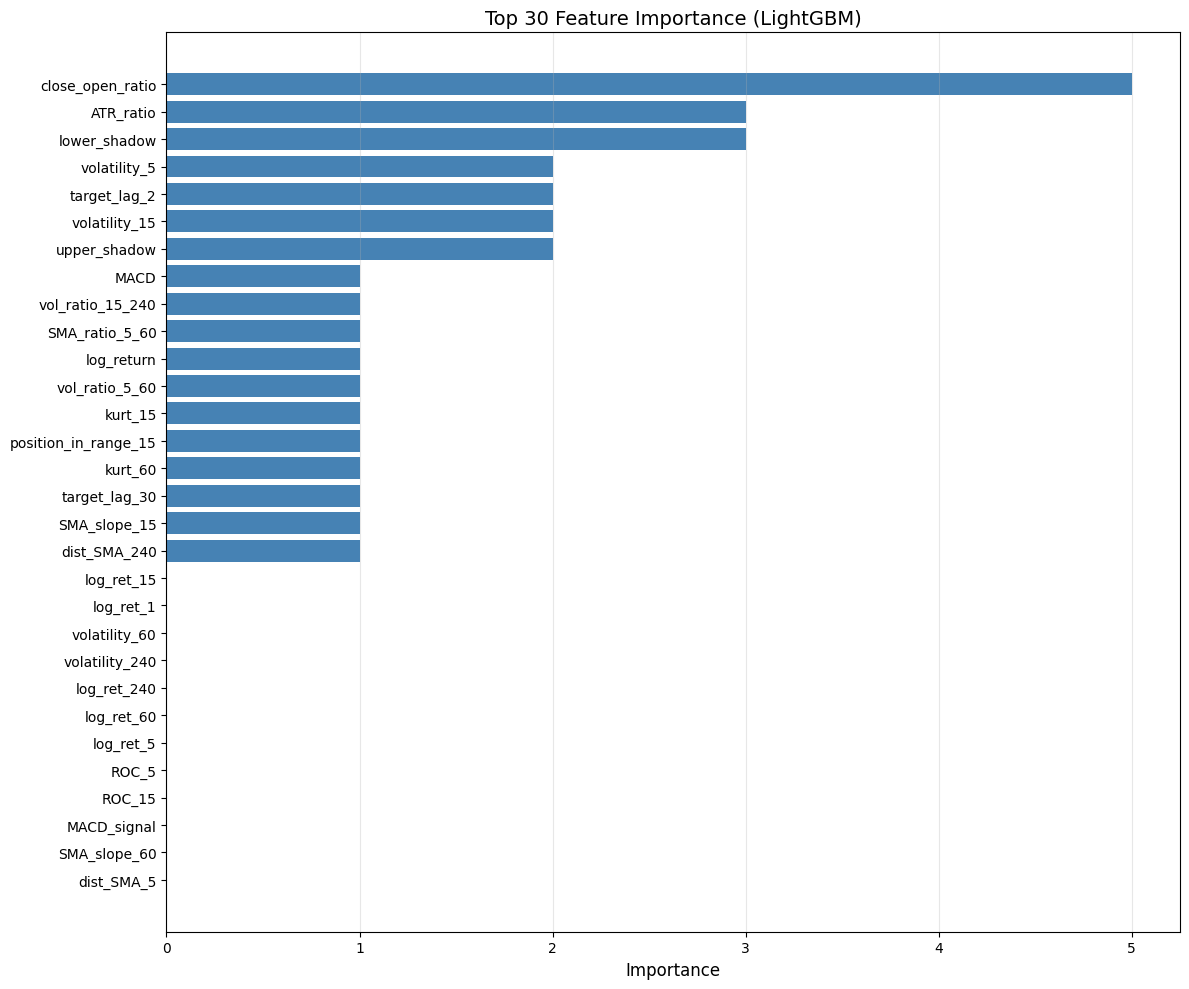

In [31]:
# 可视化
top_n = 30
top_features = feature_importance_df.head(top_n)

plt.figure(figsize=(12, 10))
plt.barh(range(top_n), top_features['importance'].values, color='steelblue')
plt.yticks(range(top_n), top_features['feature'].values)
plt.xlabel('Importance', fontsize=12)
plt.title(f'Top {top_n} Feature Importance (LightGBM)', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## 9. 测试集预测

In [32]:
# 准备测试集
max_lag = 300  # 需要的最大历史窗口

# 从训练集获取历史数据
train_tail = train_df.tail(max_lag).copy()

# 合并历史数据和测试集
test_with_history = pd.concat([train_tail, test_df], ignore_index=True)

print(f"训练集尾部: {len(train_tail)} 行")
print(f"测试集: {len(test_df)} 行")
print(f"合并后: {len(test_with_history)} 行")

训练集尾部: 300 行
测试集: 2881 行
合并后: 3181 行


In [33]:
# 创建测试集特征
print("创建测试集特征...")
test_featured = create_alpha_features(test_with_history.copy(), is_train=False)

# 只保留原始测试集行
test_featured = test_featured.tail(len(test_df)).reset_index(drop=True)

print(f"测试集特征形状: {test_featured.shape}")

创建测试集特征...
测试集特征形状: (2881, 102)


In [34]:
# 确保测试集有所有特征
available_features = [col for col in feature_cols if col in test_featured.columns]
missing_features = set(feature_cols) - set(available_features)

print(f"可用特征: {len(available_features)}/{len(feature_cols)}")

if missing_features:
    print(f"缺失特征: {missing_features}")
    for feat in missing_features:
        test_featured[feat] = 0

# 准备测试特征
X_test = test_featured[feature_cols].values.astype(np.float32)

# 处理 NaN 和 Inf
X_test = np.where(np.isinf(X_test), np.nan, X_test)
if np.isnan(X_test).any():
    print("处理测试集 NaN 值...")
    train_means = np.nanmean(X_train, axis=0)
    for i in range(X_test.shape[1]):
        mask = np.isnan(X_test[:, i])
        if mask.any():
            X_test[mask, i] = train_means[i] if not np.isnan(train_means[i]) else 0

print(f"测试集特征矩阵: {X_test.shape}")
print(f"NaN: {np.isnan(X_test).any()}, Inf: {np.isinf(X_test).any()}")

可用特征: 75/76
缺失特征: {'log_return'}
测试集特征矩阵: (2881, 76)
NaN: False, Inf: False


In [35]:
# 集成预测
print("进行集成预测...")
test_predictions = np.zeros(len(X_test))
for name, model in trained_models.items():
    pred = model.predict(X_test)
    test_predictions += weights[name] * pred
    print(f"  {name} (权重 {weights[name]:.4f}): 完成")

print(f"\n预测完成!")
print(f"预测数量: {len(test_predictions)}")
print(f"预测值范围: [{test_predictions.min():.6f}, {test_predictions.max():.6f}]")
print(f"预测值均值: {test_predictions.mean():.6f}")
print(f"预测值标准差: {test_predictions.std():.6f}")

进行集成预测...
  LightGBM (权重 0.3336): 完成
  XGBoost (权重 0.3327): 完成
  CatBoost (权重 0.3337): 完成

预测完成!
预测数量: 2881
预测值范围: [-0.001588, 0.002008]
预测值均值: 0.000134
预测值标准差: 0.000557


## 10. 生成提交文件

In [36]:
# 创建提交文件
submission_df = pd.DataFrame({
    'Timestamp': test_df['Timestamp'],
    'Prediction': test_predictions
})

# 保存
submission_dir = Path('../submissions')
submission_dir.mkdir(exist_ok=True)

submission_file = submission_dir / 'sc6117_top_tier_submission.csv'
submission_df.to_csv(submission_file, index=False)

print(f"✅ 提交文件已保存: {submission_file}")
print(f"\n提交文件预览:")
print(submission_df.head(10))
print("\n...")
print(submission_df.tail(10))

✅ 提交文件已保存: ..\submissions\sc6117_top_tier_submission.csv

提交文件预览:
            Timestamp  Prediction
0 2025-10-23 23:30:00   -0.000844
1 2025-10-23 23:45:00   -0.000907
2 2025-10-24 00:00:00   -0.001466
3 2025-10-24 00:15:00   -0.000798
4 2025-10-24 00:30:00   -0.000541
5 2025-10-24 00:45:00   -0.001138
6 2025-10-24 01:00:00   -0.000181
7 2025-10-24 01:15:00   -0.000915
8 2025-10-24 01:30:00   -0.000653
9 2025-10-24 01:45:00   -0.001030

...
               Timestamp  Prediction
2871 2025-11-22 21:15:00    0.000690
2872 2025-11-22 21:30:00    0.000686
2873 2025-11-22 21:45:00    0.000604
2874 2025-11-22 22:00:00   -0.000202
2875 2025-11-22 22:15:00    0.000498
2876 2025-11-22 22:30:00    0.000140
2877 2025-11-22 22:45:00   -0.000753
2878 2025-11-22 23:00:00   -0.000381
2879 2025-11-22 23:15:00    0.000274
2880 2025-11-22 23:30:00    0.000119


In [37]:
# 提交统计
print("\n提交文件统计:")
print(submission_df['Prediction'].describe())


提交文件统计:
count    2881.000000
mean        0.000134
std         0.000557
min        -0.001588
25%        -0.000258
50%         0.000151
75%         0.000497
max         0.002008
Name: Prediction, dtype: float64


## 11. 保存模型和特征

In [38]:
# 保存模型
model_dir = Path('../models')
model_dir.mkdir(exist_ok=True)

# 保存 LightGBM 模型
lgb_model.booster_.save_model(str(model_dir / 'sc6117_lgbm_model.txt'))
print("✅ LightGBM 模型已保存")

# 保存特征列表
feature_file = model_dir / 'sc6117_features.txt'
with open(feature_file, 'w') as f:
    for feat in feature_cols:
        f.write(f"{feat}\n")
print(f"✅ 特征列表已保存: {feature_file}")

# 保存特征重要性
importance_file = model_dir / 'sc6117_feature_importance.csv'
feature_importance_df.to_csv(importance_file, index=False)
print(f"✅ 特征重要性已保存: {importance_file}")

# 保存模型权重
weights_file = model_dir / 'sc6117_model_weights.txt'
with open(weights_file, 'w') as f:
    for name, w in weights.items():
        f.write(f"{name}: {w}\n")
print(f"✅ 模型权重已保存: {weights_file}")

✅ LightGBM 模型已保存
✅ 特征列表已保存: ..\models\sc6117_features.txt
✅ 特征重要性已保存: ..\models\sc6117_feature_importance.csv
✅ 模型权重已保存: ..\models\sc6117_model_weights.txt

✅ 特征列表已保存: ..\models\sc6117_features.txt
✅ 特征重要性已保存: ..\models\sc6117_feature_importance.csv
✅ 模型权重已保存: ..\models\sc6117_model_weights.txt


## 总结

### SC6117 Top-Tier 解决方案核心:

#### 1. 数据清洗
- 异常值截断 (Winsorization)
- 处理缺失值

#### 2. Alpha 因子工程
- **动量因子**: RSI, MACD, ROC
- **波动率因子**: ATR, 滚动标准差, 波动率比率
- **均值回归因子**: 均线乖离率, 布林带位置
- **成交量因子**: 成交量比率, OBV, 价量相关性
- **统计因子**: 偏度, 峰度, 区间位置

#### 3. 模型集成
- LightGBM + XGBoost + CatBoost
- 加权平均 (基于RMSE倒数)

#### 4. 验证策略
- **严格的时间序列切分** - 不随机！
- 训练集在前，验证集在后

### 提升建议
1. 尝试不同的集成权重
2. 添加更多技术指标
3. 特征选择 - 移除不重要的特征
4. 超参数调优